In [2]:
!pip install changeos matplotlib numpy pandas opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!tar -xzvf drive/MyDrive/changeos/out_images.tar.gz -C drive/MyDrive/changeos/

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
out_images/10300100E19A4400/post_images/post_10300100E19A4400_7_18.png
out_images/10300100E19A4400/post_images/post_10300100E19A4400_7_19.png
out_images/10300100E19A4400/post_images/post_10300100E19A4400_7_20_dam.png
out_images/10300100E19A4400/post_images/post_10300100E19A4400_7_21_dam.png
out_images/10300100E19A4400/post_images/post_10300100E19A4400_8_0.png
out_images/10300100E19A4400/post_images/post_10300100E19A4400_8_1.png
out_images/10300100E19A4400/post_images/post_10300100E19A4400_8_2.png
out_images/10300100E19A4400/post_images/post_10300100E19A4400_8_3.png
out_images/10300100E19A4400/post_images/post_10300100E19A4400_8_4.png
out_images/10300100E19A4400/post_images/post_10300100E19A4400_8_5.png
out_images/10300100E19A4400/post_images/post_10300100E19A4400_8_6_dam.png
out_images/10300100E19A4400/post_images/post_10300100E19A4400_8_7.png
out_images/10300100E19A4400/post_images/post_10300100E19A4400_8_8_dam.png
out

In [ ]:
import changeos
import cv2
import os
from pathlib import Path
from tqdm import tqdm

model = changeos.from_name('changeos_r101')

direc = '/content/drive/MyDrive/changeos/out_images/'
directories = os.listdir(direc)

for diir in directories:
  os.chdir(direc + diir)
  os.makedirs('changeos_val', exist_ok=True)
  os.makedirs('changeos_train', exist_ok=True)
  os.makedirs('changeos_test', exist_ok=True)
  os.makedirs('loc_changeos_val', exist_ok=True)
  os.makedirs('loc_changeos_train', exist_ok=True)
  os.makedirs('loc_changeos_test', exist_ok=True) 
  for split in ['test', 'train', 'val']:
    print(f'Processing {split} of {diir}:')
    post_imgs = f'post_images_{split}.txt'
    pre_imgs = f'pre_images_{split}.txt'
    pre = open(pre_imgs,'r').read().split('\n')
    post = open(post_imgs,'r').read().split('\n')
    for i, e in tqdm(zip(pre[:-1], post[:-1]), total=len(post[:-1])):
      p1_im = cv2.imread('pre_images/' + i)
      p2_im = cv2.imread('post_images/' + e)
      if (not p1_im.any() or not p2_im.any()): continue
      loc, dam = model(p1_im, p2_im)
      if p2_im is None or p1_im is None or loc is None or dam is None: break
      if not os.path.exists(f'loc_changeos_{split}/{Path(i).stem}.png'):
      cv2.imwrite(f'loc_changeos_{split}/{Path(e).stem}.png', loc)
      if not os.path.exists(f'changeos_{split}/{Path(e).stem}.png'):
      cv2.imwrite(f'changeos_{split}/{Path(e).stem}.png', dam)

Downloading: "https://github.com/Z-Zheng/ChangeOS/releases/download/v0.2/changeos_r101.pt" to /root/.cache/torch/hub/checkpoints/changeos_r101.pt
100%|██████████| 223M/223M [00:03<00:00, 59.7MB/s]


Processing test of 10300500D9F8D200:


  0%|          | 0/302 [00:11<?, ?it/s]


KeyboardInterrupt: ignored

In [3]:
import numpy as np
import torch


# Evaluator class from MS4D-Net. 
# https://github.com/YJ-He/MS4D-Net-Building-Damage-Assessment/blob/master/utils/metrics.py
# The changeos package does not provide any evaluation emtric and is equally not providing any training scripts. 
class Evaluator_tensor(object):
    """
    分类精度评定
    """

    def __init__(self, num_class, device):
        self.device = device
        self.num_class = num_class
        self.confusion_matrix = torch.zeros((self.num_class,) * 2).long().to(self.device)
        self.iou = torch.zeros(self.num_class).to(self.device)
        self.accuracy_class = torch.zeros(self.num_class).to(self.device)
        self.precision_class = torch.zeros(self.num_class).to(self.device)
        self.recall_class = torch.zeros(self.num_class).to(self.device)
        self.f1_score_class = torch.zeros(self.num_class).to(self.device)
        self.TP = torch.zeros(self.num_class).to(self.device)
        self.FP = torch.zeros(self.num_class).to(self.device)
        self.FN = torch.zeros(self.num_class).to(self.device)
        self.TN = torch.zeros(self.num_class).to(self.device)

    def Pixel_Accuracy(self):
        """
        计算并返回总体精度
        :return: 总体精度
        """
        Acc = torch.diag(self.confusion_matrix).sum() / (self.confusion_matrix.sum()+1e-8)
        return Acc

    def Pixel_Accuracy_Class(self):
        """
        计算并返回基于每类的平均精度
        :return: 基于每类的平均精度
        """
        Acc = torch.diag(self.confusion_matrix) / (self.confusion_matrix.sum(dim=1)+1e-8)
        self.accuracy_class = Acc
        Acc = torch.mean(Acc)
        return Acc

    def Mean_Intersection_over_Union(self):
        """
        计算并返回基于每类的平均IOU
        :return: 平均IOU
        """
        MIoU = torch.diag(self.confusion_matrix) / (
                torch.sum(self.confusion_matrix, dim=1) + torch.sum(self.confusion_matrix, dim=0) -
                torch.diag(self.confusion_matrix)+1e-8)
        # print(MIoU)
        self.iou = MIoU
        MIoU = torch.mean(MIoU)
        return MIoU

    def Frequency_Weighted_Intersection_over_Union(self):
        """
        计算并返回加权后的IOU
        :return:
        """
        freq = torch.sum(self.confusion_matrix, dim=1) / (torch.sum(self.confusion_matrix)+1e-8)
        iu = torch.diag(self.confusion_matrix) / (
                torch.sum(self.confusion_matrix, dim=1) + torch.sum(self.confusion_matrix, dim=0) -
                torch.diag(self.confusion_matrix)+1e-8)

        FWIoU = (freq[freq > 0] * iu[freq > 0]).sum()
        return FWIoU

    def _generate_matrix(self, gt_image, pre_image):
        """
        根据真值和预测值生成混淆矩阵
        :param gt_image: 标签图像（tensor 格式）
        :param pre_image: 预测图像（tensor 格式）
        :return: 混淆矩阵（tensor 格式）
        """
        mask = (gt_image >= 0) & (gt_image < self.num_class)
        # map=mask.clone().cpu().detach().numpy()
        # x1=np.bincount(map)
        # if x1[0]!=0:
        #     warn=1
        # classNum = np.unique(map)
        label = self.num_class * gt_image[mask] + pre_image[mask]
        count = torch.bincount(label, minlength=self.num_class ** 2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)

        # cm=confusion_matrix(gt_image.clone().cpu().detach().numpy(),pre_image.clone().cpu().detach().numpy())
        # sum1=torch.sum(confusion_matrix1)
        # if sum1!=2097152:
        #     warn = 1
        return confusion_matrix

    def add_batch(self, gt_image, pre_image):
        """
        将每个批次的标签和预测图片的像素值进行累加计算
        :param gt_image: 真值标签（tensor 格式）
        :param pre_image: 预测图片（tensor 格式）
        :return:
        """
        assert gt_image.shape == pre_image.shape
        tem_cm = self.confusion_matrix.clone().detach()
        # sum1=torch.sum(tem_cm)
        self.confusion_matrix = tem_cm + self._generate_matrix(gt_image, pre_image)

    def reset(self):
        """
        将混淆矩阵值清零
        :return:
        """
        self.confusion_matrix = torch.zeros((self.num_class,) * 2).long().to(self.device)

    def get_confusion_matrix(self):
        """
        获取混淆矩阵
        :return: 混淆矩阵
        """
        return self.confusion_matrix

    def get_base_value(self):
        """
        获取每一类的TP，FP，FN，TN值
        :return:每一类的TP，FP，FN，TN值
        """
        self.FP = self.confusion_matrix.sum(dim=0) - torch.diag(self.confusion_matrix)
        self.FN = self.confusion_matrix.sum(dim=1) - torch.diag(self.confusion_matrix)
        self.TP = torch.diag(self.confusion_matrix)
        self.TN = self.confusion_matrix.sum() - (self.FP + self.FN + self.TP)
        return self.TP, self.FP, self.FN, self.TN

    def get_iou(self):
        return self.iou

    def Pixel_Precision_Class(self):
        self.precision_class = self.TP / (self.TP + self.FP + 1e-8)
        return self.precision_class

    def Pixel_Recall_Class(self):
        self.recall_class = self.TP / (self.TP + self.FN + 1e-8)
        return self.recall_class

    def Pixel_F1_score_Class(self):
        self.f1_score_class = 2 * self.TP / (2 * self.TP + self.FP + self.FN + 1e-8)
        return self.f1_score_class

    def Kapaa_coefficient(self):
        """
        计算kappa系数(根据定义)
        需要基于混淆矩阵的计算结果
        :return: kappa系数
        """
        cm = self.confusion_matrix
        po = cm.diagonal().sum() / (cm.sum()+ 1e-8)

        sum1 = 0
        for i in range(cm.shape[0]):
            sum1 += cm[i, :].sum() * cm[:, i].sum()
        pe = sum1 / (cm.sum() * cm.sum()+ 1e-8)
        return (po - pe) / (1 - pe + 1e-8)

    def Kapaa_coefficient_sklearn(self):
        """
        计算kappa系数（sklearn的算法）
        需要基于混淆矩阵的计算结果
        :return: kappa系数
        """
        cm = self.confusion_matrix
        n_classes = cm.shape[0]
        sum0 = torch.sum(cm, dim=0)
        sum1 = torch.sum(cm, dim=1)
        expected = torch.outer(sum0, sum1) / (torch.sum(sum0)+ 1e-8)

        w_mat = torch.ones([n_classes, n_classes], dtype=torch.int)
        w_mat.flat[:: n_classes + 1] = 0

        k = torch.sum(w_mat * cm) / (torch.sum(w_mat * expected) + 1e-8)
        return 1 - k


if __name__ == '__main__':
    evaluator = Evaluator_tensor(5, 0)
    a = torch.tensor([1, 0, 2, 1, 3, 1, 0, 4, 0, 0]).to('cuda')
    b = torch.tensor([1, 1, 2, 1, 2, 3, 0, 4, 1, 1]).to('cuda')
    evaluator.add_batch(a, b)

    acc = evaluator.Pixel_Accuracy()
    acc_class = evaluator.Pixel_Accuracy_Class()
    miou = evaluator.Mean_Intersection_over_Union()
    fwiou = evaluator.Frequency_Weighted_Intersection_over_Union()
    confusion_matrix1 = evaluator.get_confusion_matrix()
    TP, FP, FN, TN = evaluator.get_base_value()
    iou = evaluator.get_iou()
    prec = evaluator.Pixel_Precision_Class()
    recall = evaluator.Pixel_Recall_Class()
    f1_score = evaluator.Pixel_F1_score_Class()
    kappa_coe = evaluator.Kapaa_coefficient()
    print('Class:    ', 5, ' Average')
    np.set_printoptions(formatter={'float': '{: 6.6f}'.format})
    print('IoU:      ', iou)
    print('Precision:', prec)
    print('Recall:   ', recall)
    print('F_Score:  ', f1_score)
    np.set_printoptions(formatter={'int': '{:14}'.format})
    print('Confusion_matrix:')
    print(confusion_matrix1)
    print('Kappa_Coefficient:{:10.6f}'.format(kappa_coe))


Class:     5  Average
IoU:       tensor([0.2500, 0.3333, 0.5000, 0.0000, 1.0000], device='cuda:0')
Precision: tensor([1.0000, 0.4000, 0.5000, 0.0000, 1.0000], device='cuda:0')
Recall:    tensor([0.2500, 0.6667, 1.0000, 0.0000, 1.0000], device='cuda:0')
F_Score:   tensor([0.4000, 0.5000, 0.6667, 0.0000, 1.0000], device='cuda:0')
Confusion_matrix:
tensor([[1, 3, 0, 0, 0],
        [0, 2, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1]], device='cuda:0')
Kappa_Coefficient:  0.350649


In [ ]:
import os
import cv2
import glob
from tqdm import tqdm
from pickle import dump, load
import re
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, x, y):
        super(MyDataset, self).__init__()
        assert x.shape[0] == y.shape[0]
        self.x = x
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

direc = '/content/drive/MyDrive/changeos/out_images/'
directories = os.listdir(direc)

for diir in directories:
  os.chdir(direc + diir)
  for split in ['test', 'train', 'val']:
    pred_dir = f'changeos_{split}/'
    pred_msks = os.listdir(pred_dir)
    gt_dir = 'masks/'
    gt_msks = os.listdir(gt_dir)
    if not os.path.exists(f"{split}_{diir}_preds_cls.nparray"):
      preds = []
      gts = []
      for pred_msk in tqdm(pred_msks):
        pred = cv2.imread(pred_dir + pred_msk)
        gt_f = pred_msk.replace('post', 'mask')
        gt = cv2.imread(f'{gt_dir}/{gt_f}')
        preds.append(pred)
        gts.append(gt)
      filehandler = open(f"{split}_{diir}_preds_cls.nparray","wb")
      dump(preds,filehandler)
      filehandler.close()
      filehandler = open(f"{split}_{diir}_gts_cls.nparray","wb")
      dump(gts,filehandler)
      filehandler.close()

100%|██████████| 178/178 [00:01<00:00, 129.34it/s]


In [ ]:
from pickle import dump, load
import re
from torch.utils.data import Dataset, DataLoader


direc = '/content/drive/MyDrive/changeos/out_images/'
directories = os.listdir(direc)


class MyDataset(Dataset):
    def __init__(self, x, y):
        super(MyDataset, self).__init__()
        assert x.shape[0] == y.shape[0]
        self.x = x
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

for diir in directories:
  os.chdir(direc + diir)
  for split in ['test', 'train', 'val']:     
    evaluator = Evaluator_tensor(5, 0)
    file = open(f"{split}_{diir}_preds_cls.nparray",'rb')
    preds = load(file)
    file.close()
    file2 = open(f"{split}_{diir}_gts_cls.nparray",'rb')
    gts = load(file2)
    file2.close()
    print(f"Data: {diir}, Split: {split}, Samples: {len(preds)}")
    my_data = MyDataset(np.array(gts), np.array(preds))
    my_data_loader = DataLoader(my_data, batch_size=1, shuffle=True)
    for _, data in enumerate(my_data_loader):
      gt, pred = data
      gt_tens = torch.tensor(np.array(gt)).cuda()
      pred_tens = torch.tensor(np.array(pred)).cuda()
      
      evaluator.add_batch(gt_tens, pred_tens)

    acc = evaluator.Pixel_Accuracy().cpu().detach().numpy()
    acc_class = evaluator.Pixel_Accuracy_Class().cpu().detach().numpy()
    miou = evaluator.Mean_Intersection_over_Union().cpu().detach().numpy()
    fwiou = evaluator.Frequency_Weighted_Intersection_over_Union().cpu().detach().numpy()
    cm = evaluator.get_confusion_matrix().cpu().detach().numpy()
    TP, FP, FN, TN = evaluator.get_base_value()
    iou = evaluator.get_iou().cpu().detach().numpy()
    f1_score = evaluator.Pixel_F1_score_Class().cpu().detach().numpy()
    kappa_core = evaluator.Kapaa_coefficient().cpu().detach().numpy()
    prec = evaluator.Pixel_Precision_Class().cpu().detach().numpy()
    recall = evaluator.Pixel_Recall_Class().cpu().detach().numpy()


    print(f'Dataset:    {diir}:      Split: {split}')
    print('________________________________________________________________')
    print(f'Precision:       {prec}')
    print(f'Accuracy:        {acc}')
    print(f'IOU:             {iou}')
    print(f'Recall:          {recall}')
    print(f'F1 Score:        {f1_score}')
    print(f'FWIOU:           {fwiou}')
    print(f'MIOU:            {miou}')
    print(f'Kappa:           {kappa_core}')
    print(f'Accuracy class:  {acc_class}')
    print('\n')
    print(f'CONFUSION MATRIX')
    print(cm)
    print(f'_______________________________________________________________')
    print('\n')
    print(f'CONFUSION MATRIX, relative')
    print(cm/sum(cm))  
    print('################################################################')
    print('################################################################')
    print('\n\n\n')
#pred = cv2.imread(dmg_dir + dmg_msks[0])

Data: 10300500D9F8D200, Split: test, Samples: 302
Dataset:    10300500D9F8D200:      Split: test
________________________________________________________________
Precision:       [0.84139436 0.5003852  0.         0.01977843 0.07104616]
Accuracy:        0.7670665383338928
IOU:             [0.7656821  0.2712059  0.         0.01806064 0.00333104]
Recall:          [0.8948372  0.3719166  0.         0.17214966 0.00348273]
F1 Score:        [0.86729324 0.42669073 0.         0.03548048 0.00663997]
FWIOU:           0.6461891531944275
MIOU:            0.21165595948696136
Kappa:           0.3088802993297577
Accuracy class:  0.28847724199295044


CONFUSION MATRIX
[[     163655727       16620780          51042        2476173
           85116]
 [      28241901       18395964          61413        2719893
           43437]
 [        952767         474243              0          70557
            6267]
 [        167511         400872              0         118194
               0]
 [       1487463     

In [ ]:
def display_segmentation_mask(mask):
    # Define the color codes for each class
    color_codes = {
        0: [0, 0, 0],     # background (black)
        1: [0, 255, 0],   # no visible damage (green)
        2: [255, 255, 0], # possibly damaged (yellow)
        3: [255, 165, 0], # damaged (orange)
        4: [255, 0, 0]    # destroyed (red)
    }
    
    # Create an empty array for the colored mask
    height, width = mask.shape
    colored_mask = np.zeros((height, width, 3), dtype=np.uint8)
    
    # Loop over each pixel in the mask and set the corresponding color
    for i in range(height):
        for j in range(width):
            pixel_class = mask[i, j]
            colored_mask[i, j] = color_codes[pixel_class]
    
    # Display the colored mask using OpenCV
    return colored_mask

Prediction for dataset: 10300100E19A4400 Split:test, tile: 2_14


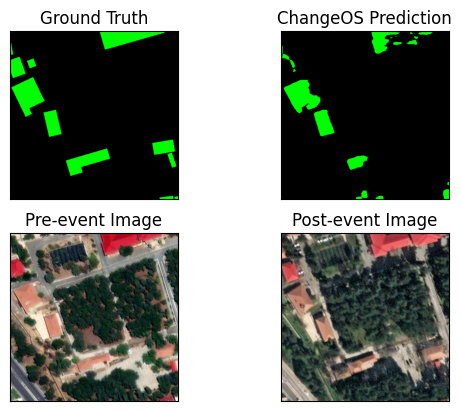

In [ ]:
import random
import re

for diir in directories:
  os.chdir(direc + diir)
  os.makedirs('prediction_examples/', exist_ok=True)

direc = '/content/drive/MyDrive/changeos/out_images/'
os.chdir(direc)
directories = os.listdir(direc)
random_set = random.choice(directories)

random_set = '10300100E19A4400'
os.chdir(random_set)
split = random.choice(['test', 'val', 'train'])
split = 'test'
pred_dir = f'changeos_{split}/'
dmg_msks = os.listdir(pred_dir)

gt_dir = f'masks/'

gt_msks = os.listdir(gt_dir)


dmg_msk = random.choice(dmg_msks)


dmg_msk = f'post_{random_set}_2_14.png'
gt_msk = dmg_msk.replace('post', 'mask')

pred = cv2.imread(pred_dir + dmg_msk, 0)
gt = cv2.imread(gt_dir + f'{gt_msk}', 0)

pre_im_dir = 'pre_images/'
post_im_dir = 'post_images/'


pre_i = dmg_msk.replace('post', 'pre')
pre_im = cv2.imread(pre_im_dir + f'{pre_i}')[:,:,::-1]
post_im = cv2.imread(post_im_dir + f'{dmg_msk}')[:,:,::-1]

gt_im = display_segmentation_mask(pred)
pred_im = display_segmentation_mask(gt)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
f, axarr = plt.subplots(2, 2)

axarr[0,0].imshow(pred_im)
axarr[0,1].imshow(gt_im)
axarr[1,0].imshow(pre_im)
axarr[1,1].imshow(post_im)

axarr[0,0].title.set_text('Ground Truth')
axarr[0,1].title.set_text('ChangeOS Prediction')
axarr[1,0].title.set_text('Pre-event Image')
axarr[1,1].title.set_text('Post-event Image')


plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
print(f'Prediction for dataset: {random_set} Split:{split}, tile: {dmg_msk.replace(f"post_{random_set}_", "").replace(".png", "")}')
plt.savefig('prediction_examples/' + f'{split}_{dmg_msk.replace(f"post_{random_set}_", "changeos_prediction_")}')
plt.show()

In [ ]:
dmg_msk

'post_10300100E291D100_16_17.png'

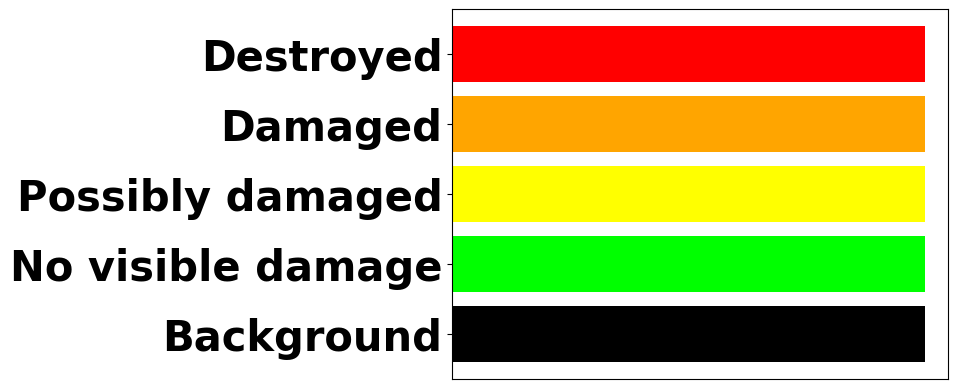

In [ ]:
fig, ax = plt.subplots()

left = np.array(range(5))
height = np.ones(5)

color_codes = {
    0: [0, 0, 0],     # background (black)
    1: [0, 255, 0],   # no visible damage (green)
    2: [255, 255, 0], # possibly damaged (yellow)
    3: [255, 165, 0], # damaged (orange)
    4: [255, 0, 0]    # destroyed (red)
}


label = np.array([
    "Background",
    "No visible damage",
    "Possibly damaged",
    "Damaged",
    "Destroyed"
    ])
col = []
for i in range(5):
    col.append([x/255 for x in color_codes[i]])

plt.barh(left, height, tick_label=label, align="center",color=col) 
plt.setp(plt.gcf().get_axes(), xticks=[])

font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 22}
import matplotlib
matplotlib.rc('font', **font)

plt.show()